## Aligning single-cell spatial transcriptomics datasets simulated with non-linear disortions

In this blog post, I will use our recently developed tool `STalign` to align two single-cell resolution spatial transcriptomic datasets of coronal sections of the mouse brain assayed by MERFISH and provided by [Vizgen](https://vizgen.com/applications/neuroscience-showcase/). 

### Introduction

As we've [explored in a previous blog post](https://jef.works/blog/2023/04/16/aligning-spatial-transcriptomics-data-with-stalign/), spatial transcriptomics (ST) allow us to measure how genes are expressed within thin tissue slices. Particularly as we begin applying ST to tissues like brain, kidney, heart, and so forth in both healthy and diseased settings, we may be interested in comparing gene expression and cell-type compositional differences at matched spatial locations within similar tissue structures. Such spatial comparisons demand alignment of these ST datasets. 

As described in our [recently updated bioRxiv preprint](https://www.biorxiv.org/content/10.1101/2023.04.11.534630v2), such spatial comparisons are challenging because of both technical challenges such as in sample collection, where the experimental process may induce tissue warps and other structural distortions but also biological variation such as natural inter-individual tissue structural differences. 

Here, I will simulate an ST dataset of a brain tissue section that has been warped during the experimental data collection process and evaluate how well `STalign` is able to align it to the original un-warped brain tissue section. A successful alignment should recover the original cell positions within some reasonable amount of error. 

### Simulation

I have already installed `STalign` using the tutorials available on our [Github repo: https://github.com/JEFworks-Lab/STalign](https://github.com/JEFworks-Lab/STalign). I am using a `jupyter notebook` to run `STalign`. A copy of this notebook is available here for you to follow along and also modify as you explore for yourself: 

In [1]:
# import STalign
from STalign import STalign

On our [STalign Github repo](https://github.com/JEFworks-Lab/STalign), we have already downloaded single cell spatial transcriptomics datasets assayed by MERFISH and provided by [Vizgen](https://vizgen.com/applications/neuroscience-showcase/) and placed the files in a folder called `merfish_data`.

Clone the repo or just download the relevant file (`datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz`) so you can read in the cell information for the first dataset using `pandas` as `pd`.

In [2]:
import pandas as pd

# Single cell data 1
# read in data
fname = '../merfish_data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz'
df1 = pd.read_csv(fname)
print(df1.head())

                                Unnamed: 0  fov       volume    center_x   
0  158338042824236264719696604356349910479   33   532.778772  617.916619  \
1  260594727341160372355976405428092853003   33  1004.430016  596.808018   
2  307643940700812339199503248604719950662   33  1267.183208  578.880018   
3   30863303465976316429997331474071348973   33  1403.401822  572.616017   
4  313162718584097621688679244357302162401   33   507.949497  608.364018   

      center_y       min_x       max_x        min_y        max_y  
0  2666.520010  614.725219  621.108019  2657.545209  2675.494810  
1  2763.450012  589.669218  603.946818  2757.013212  2769.886812  
2  2748.978012  570.877217  586.882818  2740.489211  2757.466812  
3  2766.690012  564.937217  580.294818  2756.581212  2776.798812  
4  2687.418010  603.061218  613.666818  2682.493210  2692.342810  


For alignment with `STalign`, we only need the cell centroid information so we can pull out this information. We can further visualize the cell centroids to get a sense of the variation in cell density that we will be relying on for our alignment by plotting using `matplotlib.pyplot` as `plt`. 

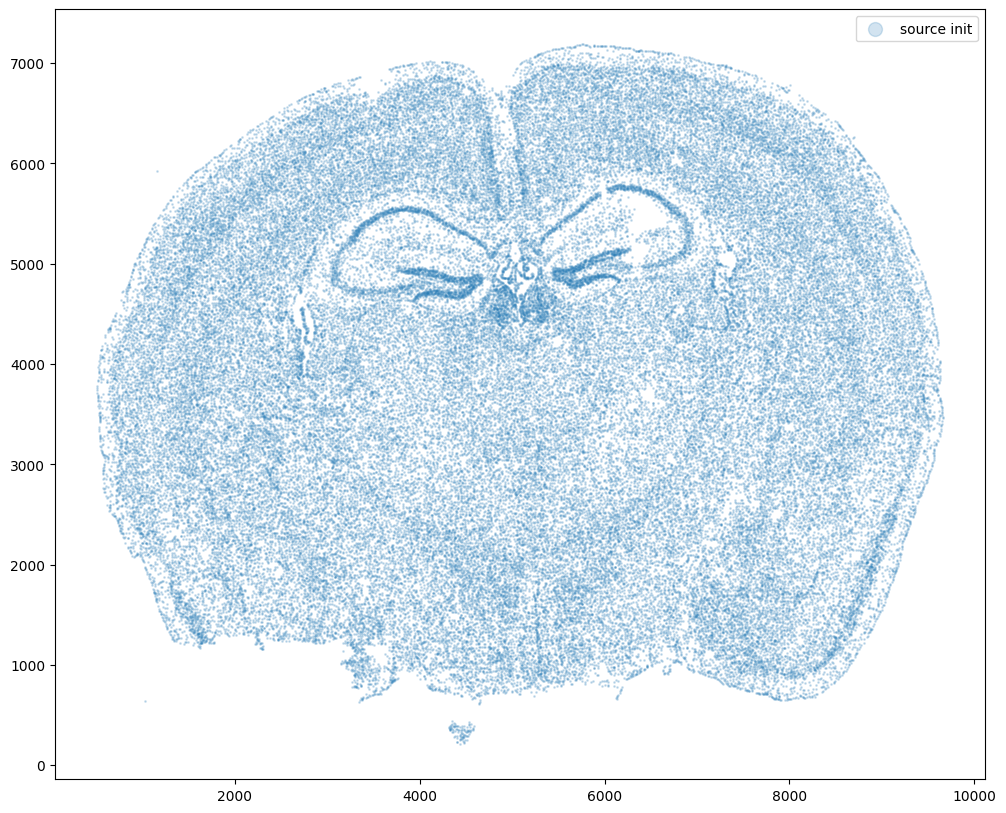

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

# get cell centroid coordinates
xI0 = np.array(df1['center_x'])
yI0 = np.array(df1['center_y'])

# plot
fig,ax = plt.subplots()
ax.scatter(xI0,yI0,s=1,alpha=0.2, label='source init')
ax.legend(markerscale = 10)

Now let's warp the cell coordinates as if we had squished the tissue during the experimental data collection process. If you are curious whether such simulated warps are realistic, think about how tissues are inherently 3D so in order to make these thin, effectively 2D tissue sections, we need to make slices (typically via a technique called cryosectioning). And in making these slices, we may squish the tissue or even cause tears! In this simulation, we will focus on simulation a scenario where the tissue and all the cell positions get squished a little in both the x and y direction. 

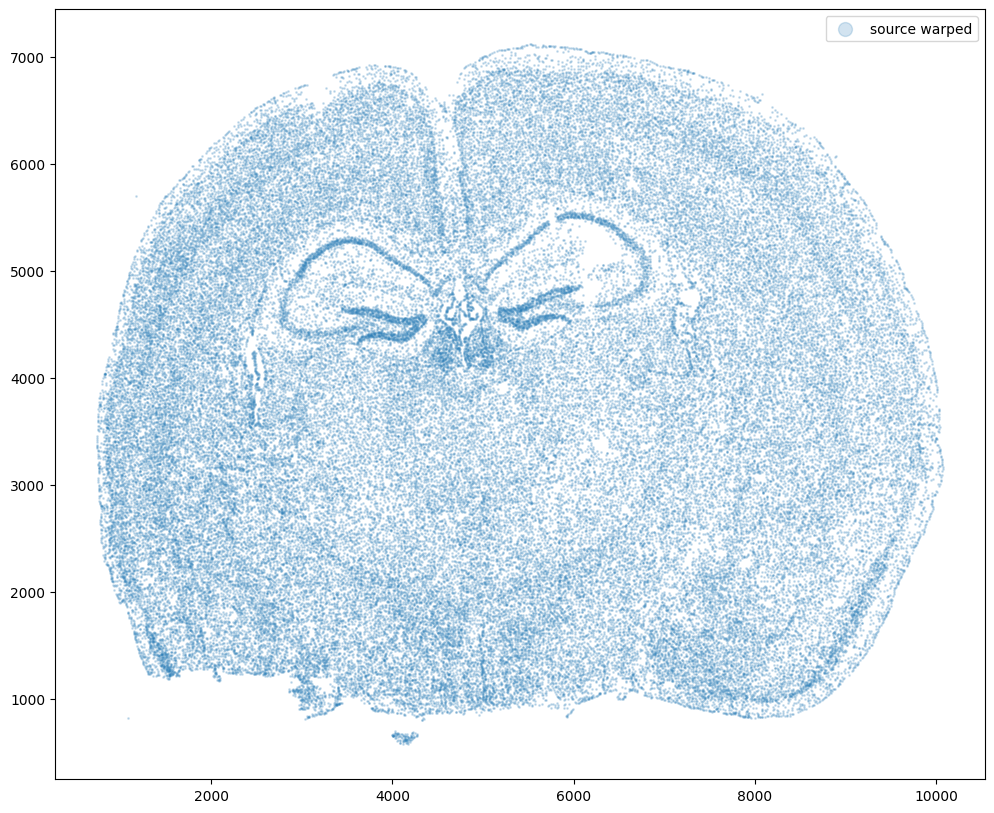

In [4]:
# warp
xI = pow(xI0,1.25)/10+500
yI = pow(yI0,1.25)/10+500

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source warped')
ax.legend(markerscale = 10)

Now let's say we have a second ST dataset of the same tissue. In this case, we will just use the original cell coordinates for this second ST dataset. 

This represents, in my opinion, a somewhat overly idealistic scenario since, in reality, two real ST datasets will never have perfect single-cell resolution correspondence. This is because real ST datasets can come from different individuals/animals with their own biological variation. Real ST datasets can also come from serial sections of the same tissue block from the same individual/animal but even in that case, there is still generally not a perfect one-to-one match for every cell at every location across the tissue (particularly for mamallian tissues). But let's try it anyway. 

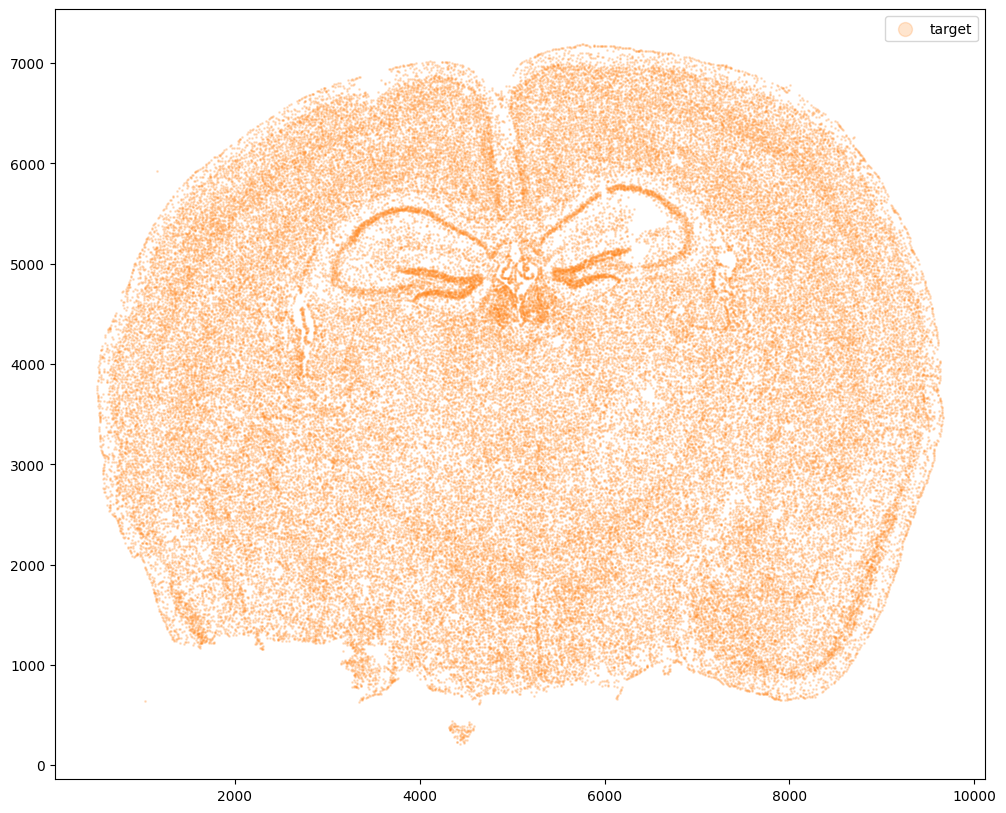

In [5]:
# Single cell data 1
# just original coordinates
xJ = xI0
yJ = yI0

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=0.2,c='#ff7f0e', label='target')
ax.legend(markerscale = 10)

Now that's see what our two ST datasets look like when they are overlayed. As you might expect, linear "affine" adjustments such as rotations and translations will not be sufficient to align these two ST datasets. A non-linear alignment is needed due to our induced non-linear warping.

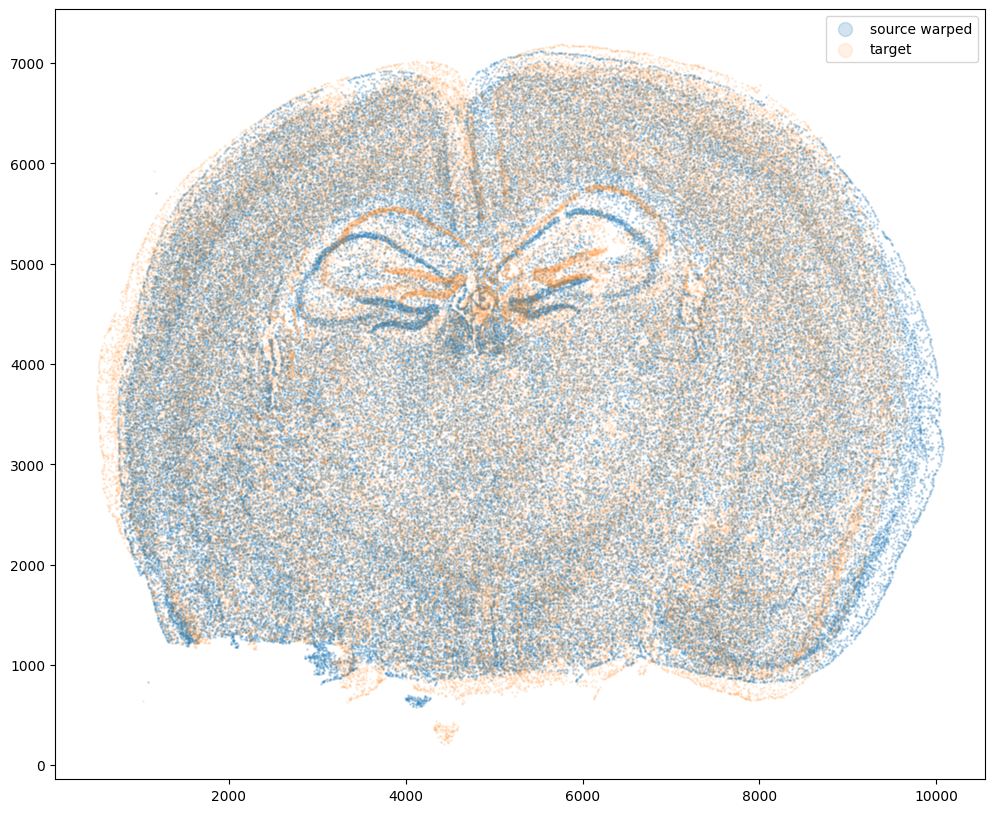

In [6]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.2, label='source warped')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label= 'target')
ax.legend(markerscale = 10)

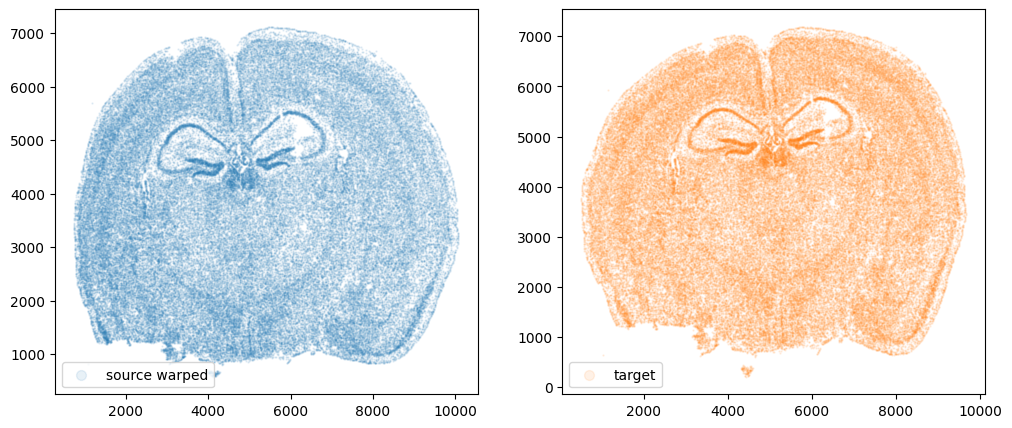

In [17]:
plt.rcParams["figure.figsize"] = (12,5)
fig,ax = plt.subplots(1,2)
ax[0].scatter(xI,yI,s=0.5,alpha=0.1, label='source warped')
ax[1].scatter(xJ,yJ,s=0.5,alpha=0.1, c='#ff7f0e',label='target')
ax[0].legend(markerscale = 10, loc = 'lower left')
ax[1].legend(markerscale = 10, loc = 'lower left')

Again, ST gives us not only positions of cells but also what genes these cells express. From these gene expression information, we may also infer cell-types. We may be interested in asking questions about how cells within a particular small spatial region of the tissue compare in terms of their gene expression or cell-type identity across these two ST datasets. In order to ask such questions, we need to perform spatial alignment in order to compare apples to apples.  


### Performing spatial alignment with `STalign`

So we will use `STalign` to align these two ST datasets using image varifolds and diffeomorphic metric mapping. I encourage you to check out the Online Methods section of our [bioRxiv preprint](https://www.biorxiv.org/content/10.1101/2023.04.11.534630v2) if you are interested in learning more about how this is done methodologically speaking. For now, let's just focus on running `STalign`. We will start with rasterizing the ST datasets. 

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


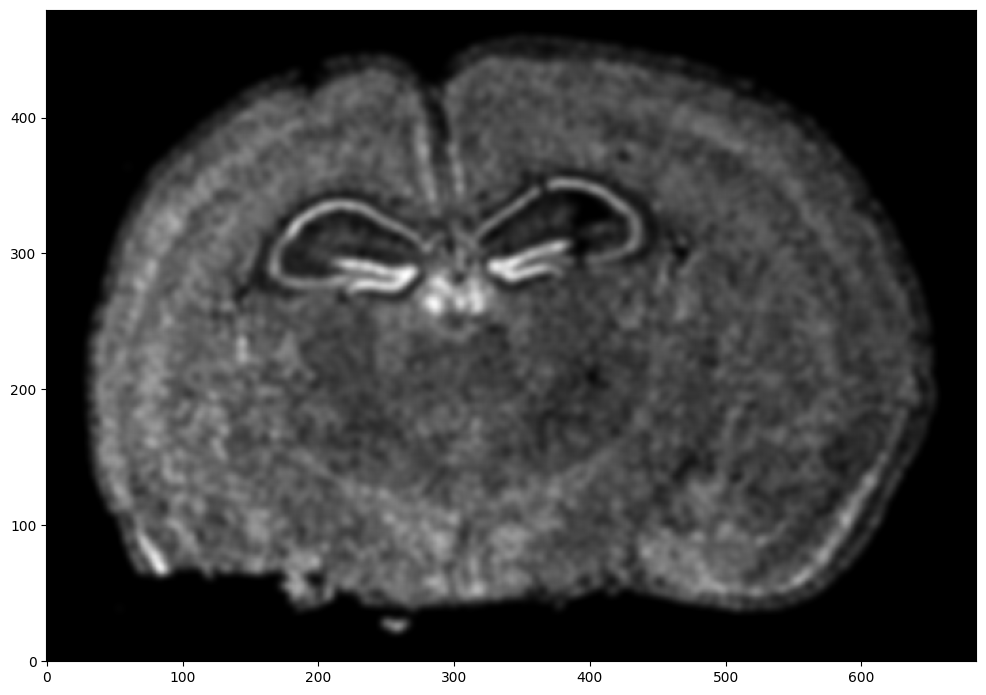

In [7]:
# rasterize at 15um resolution (assuming positions are in um units) and plot
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=15,blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

Repeat rasterization for target dataset.

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


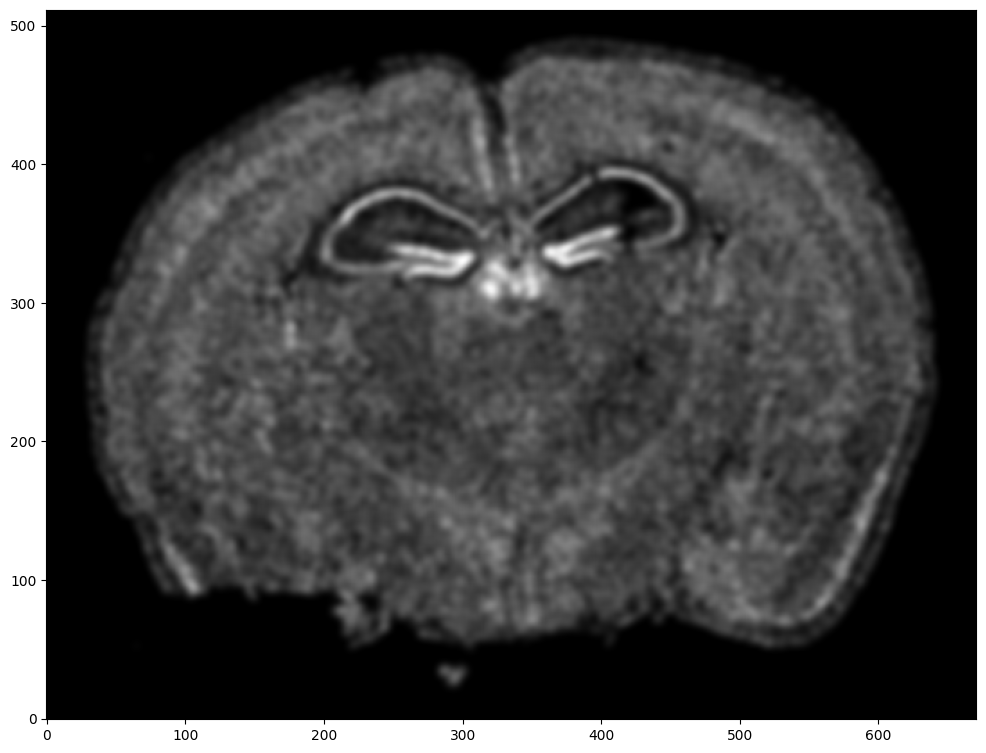

In [8]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=15, blur=1.5)
ax = fig.axes[0]
ax.invert_yaxis()

We can also plot the rasterized images next to each other.

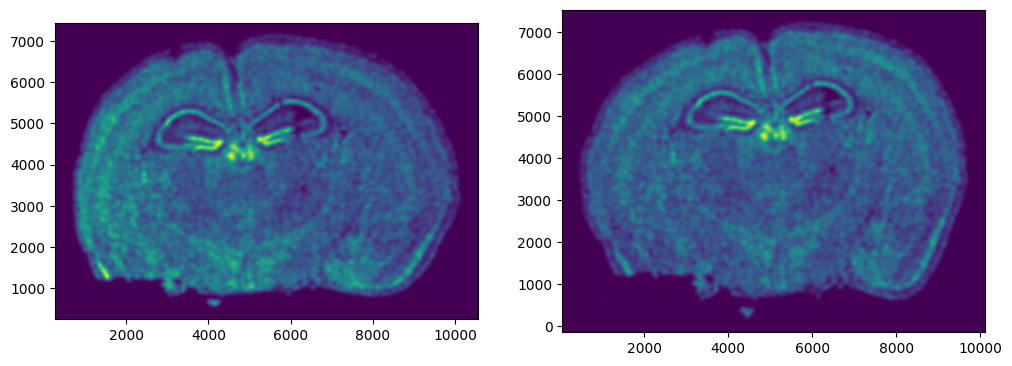

In [9]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow(I[0], extent=extentI) 
ax[1].imshow(J[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

Now we will perform our alignment. There are many parameters that can be tuned for performing this alignment. If we don't specify parameters, defaults will be used. 

/Users/jeanfan/mambaforge/lib/python3.9/site-packages/STalign/STalign.py:1036: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/Users/jeanfan/mambaforge/lib/python3.9/site-packages/STalign/STalign.py:1037: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/Users/jeanfan/mambaforge/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid

CPU times: user 3min 47s, sys: 2min 13s, total: 6min
Wall time: 3min 11s


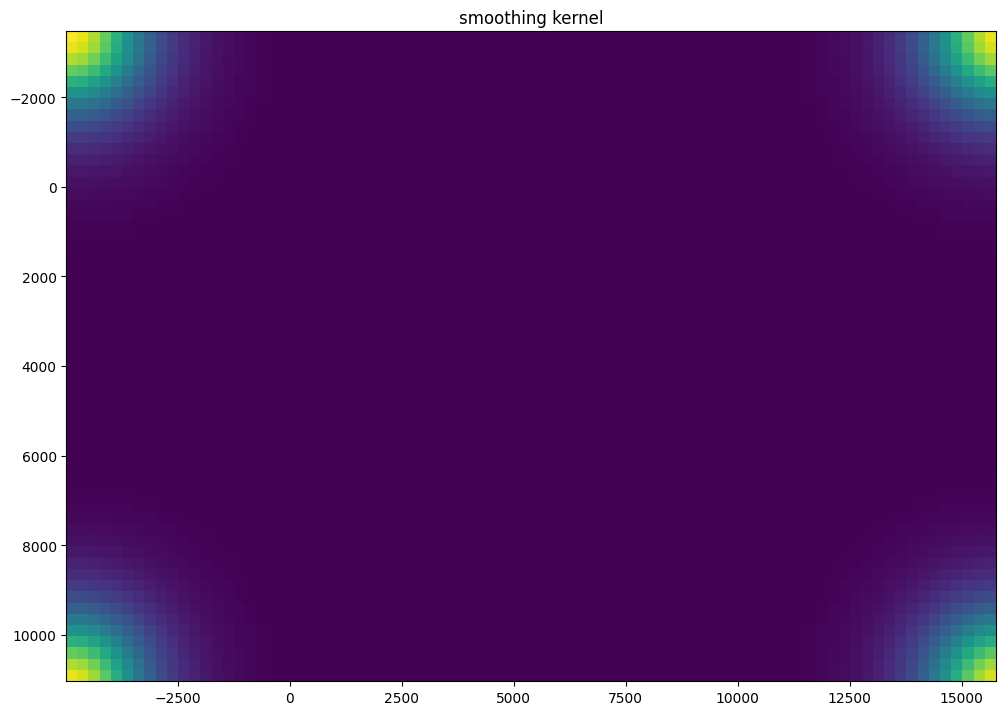

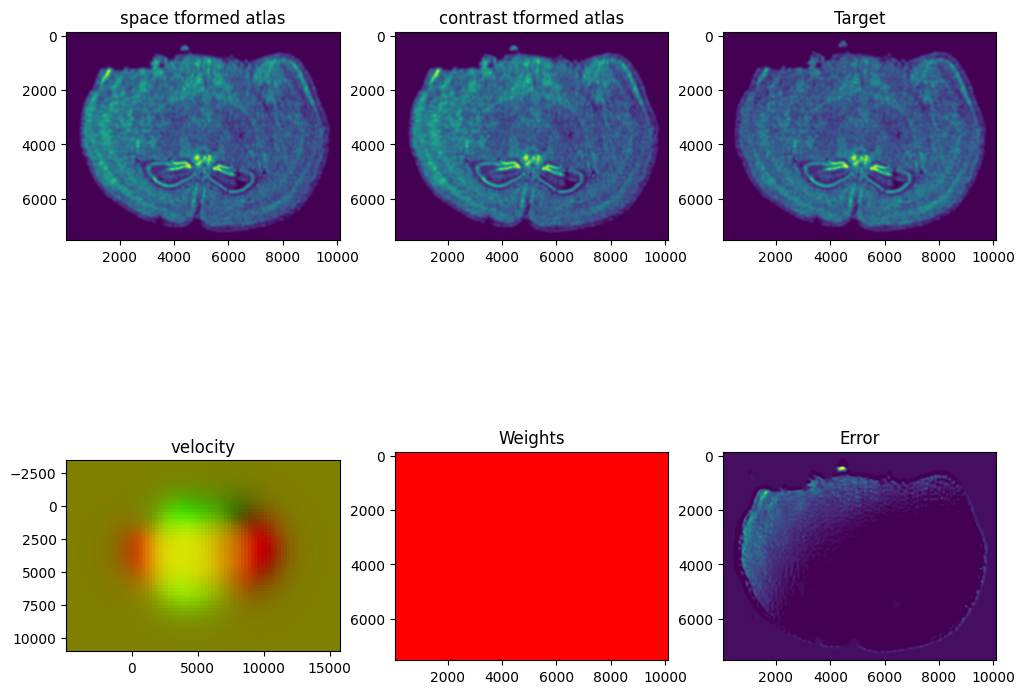

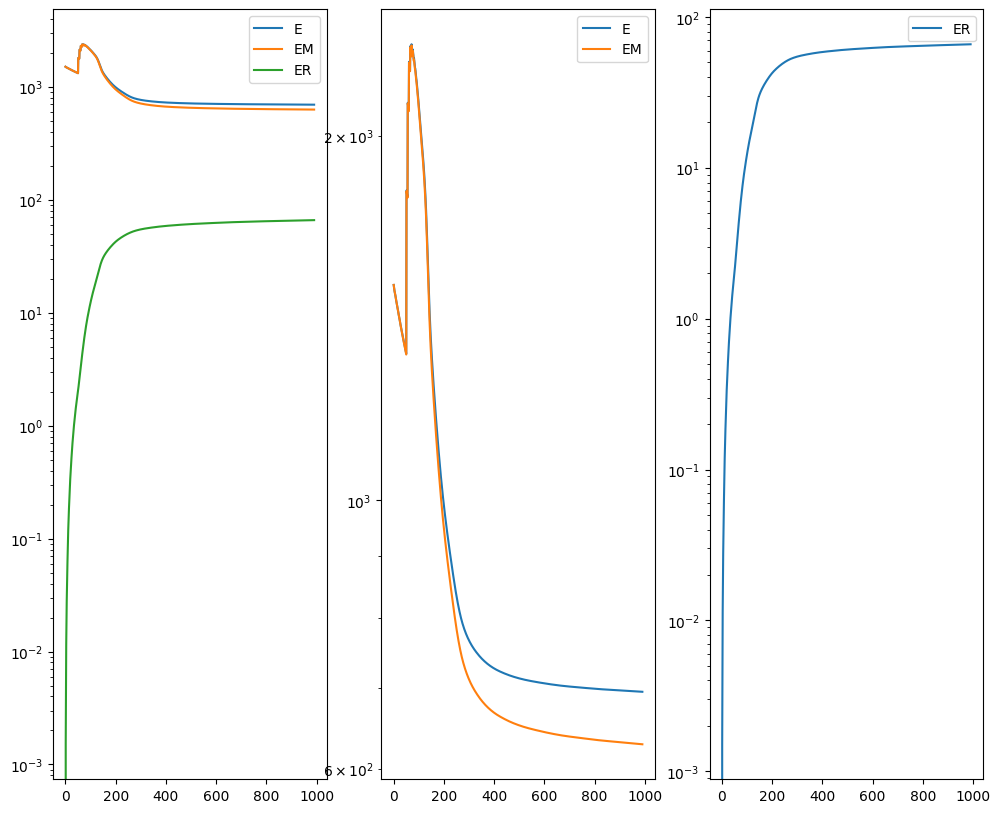

In [10]:
%%time

# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000
          }

out = STalign.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

I am running this on my Macbook laptop using the CPU. This alignment would be much faster on the GPU but not everyone may have access to such GPU computers. We can still complete an alignment with `STalign` in a reasonable amount of time on the CPU (with "reasonable" defined as the time it takes for me to make a cup of tea ;P). In this case, it takes < 5 minutes to run 1000 iterations with the default step sizes and other settings. 

In [11]:
# get necessary output variables
A = out[0]
v = out[1]
xv = out[2]

`STalign` has learned a diffeomorphic mapping needed to align the two image representations of the ST datasets. Given this, we can now apply our learned transform to the original sets of single cell centroid positions to achieve their new aligned positions.

In [12]:
# apply transform to original points
tpointsI= STalign.transform_points_atlas_to_target(xv,v,A, np.stack([yI, xI], 1))

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = np.array(tpointsI[:,1])
yI_LDDMM = np.array(tpointsI[:,0])

Now that's see what our two ST datasets look like when they are overlayed after the warped ST dataset has been aligned. 

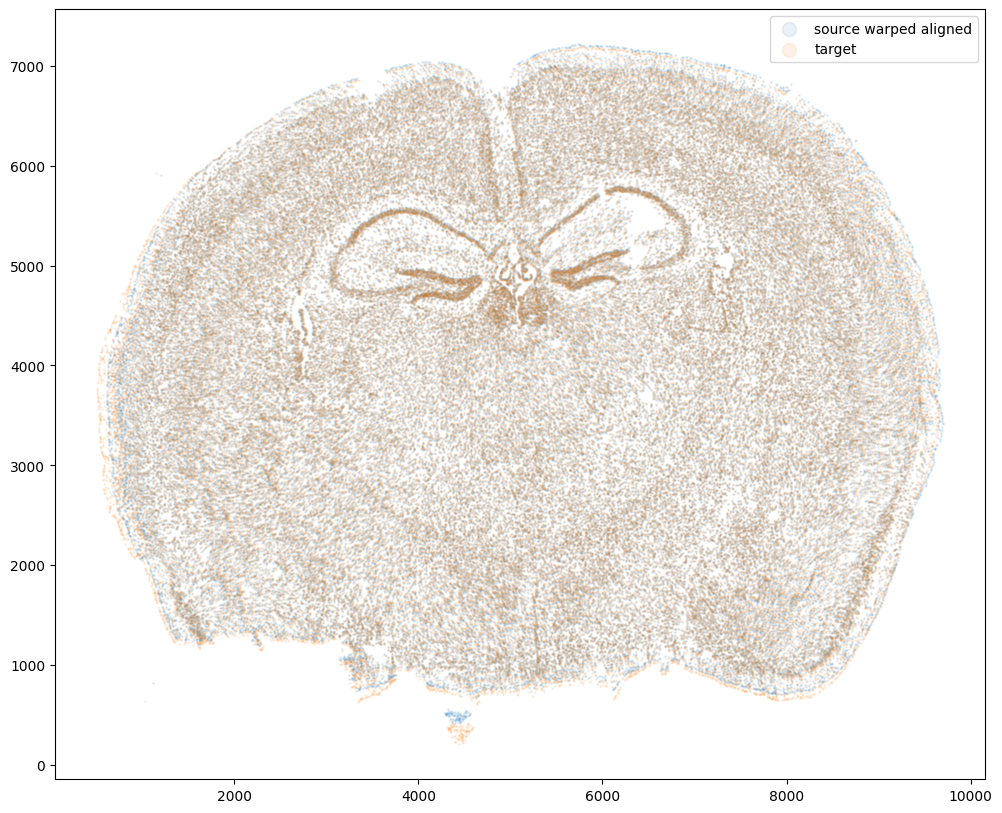

In [13]:
# plot results
fig,ax = plt.subplots()
#ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source warped aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

We can also compare before and after alignment side by side. Looks pretty good! The cell positions in the two ST datasets effectively overlap!

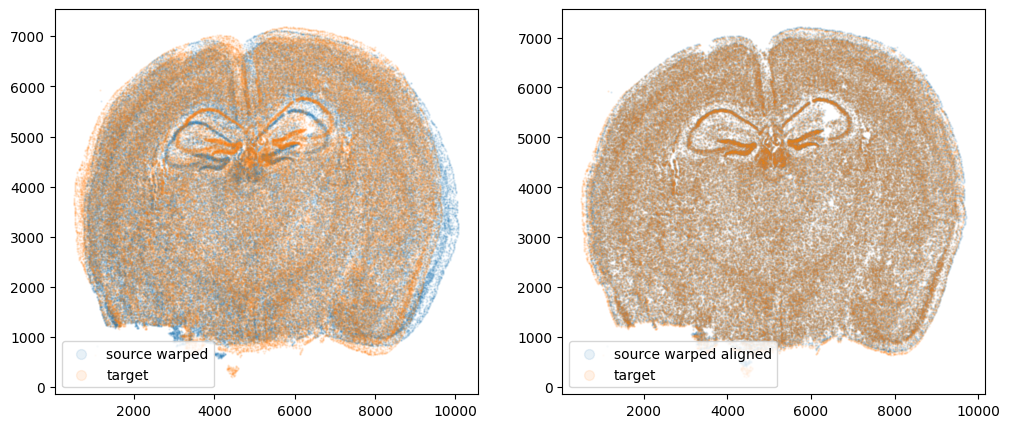

In [14]:
plt.rcParams["figure.figsize"] = (12,5)
fig,ax = plt.subplots(1,2)
ax[0].scatter(xI,yI,s=0.5,alpha=0.1, label='source warped')
ax[0].scatter(xJ,yJ,s=0.5,alpha=0.1, label='target')
ax[1].scatter(xI_LDDMM,yI_LDDMM,s=0.5,alpha=0.1, label = 'source warped aligned') 
ax[1].scatter(xJ,yJ,s=0.5,alpha=0.1, label='target')
ax[0].legend(markerscale = 10, loc = 'lower left')
ax[1].legend(markerscale = 10, loc = 'lower left')

### Evaluating performance

Let's quantify performance beyond just visual inspection. How far off are our aligned cell coordinates compared to the original? A successful alignment should effectively recover the original cell coordinates before warping within some reasonable error range. Let's calculate a mean-squared-error between the coordinates before and after alignment.

In [15]:
from sklearn.metrics import mean_squared_error

err_init = mean_squared_error([xI0, yI0], [xI, yI], squared=False)
print(err_init)

err_aligned = mean_squared_error([xI0, yI0], [xI_LDDMM, yI_LDDMM], squared=False)
print(err_aligned)

229.1068166826202
9.679364699685218


Note these units are in microns. We are effectively on average within 1 cell (10 microns) away from the true original cell positions. Given that we aligned with `dx=15` or 15 micron resolution, this is a reasonable degree of error. Such error may be further decreased with longer iterations or stricter penalties for mismatching. However, this exploration will be left as an exercise for the reader. 


## Try it out for yourself!
- What happens if you run for more iterations? What about 2000 iterations? What if you change the default parameters to have larger step sizes, etc?
- What happens if you warp the data in other ways? 
- What happens if you try a different dataset?
- What happens if you use this simulation approach to compare to other methods?